<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Nifty_50_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nifty 50 Time Series Forecasting**

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Expainatory Data Analysis](#3)
  4. [Covid Period and Recovery](#4)
  5. [Stationary Conversion](#5)
  6. [Implemneting XGBoost](#6)
  7. [Hyperparameter Tuning - XGBoost](#7)
  8. [Auto Corelation](#8)
  9. [ARIMA](#9)
  10. [Facebook Prophet](#10)
  11. [Summary](#11)
  12. [Future Work](#12)
  13. [References](#13)

# 1: AboutDataset <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

The data is the price history and trading volumes of the fifty stocks in the index NIFTY 50 from NSE (National Stock Exchange) India. All datasets are at a day-level with pricing and trading values split across .cvs files for each stock along with a metadata file with some macro-information about the stocks itself. The data spans from 1st January, 2000 to 30th April, 2021.

The dataset contains the following features

- Date - Trading day
- Symbol - Stock Name
- Prev Close - Closing price of the stock on previous day
- Open - Openning Price on the given day
- High - Highest Price on the given day
- Low - Lowest Price on the given day
- Last - Last Price on the given day
- Close - Closing Price on the given day
- VWAP - Average price on the stock traded througout the day

Since we have data of 50 stocks avaliable, It would make sense to pick one stock at a time and perform the analysis, Hence I am picking Titan for my analysis

# 2: Loading the dataset Preprocessing <a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

We load the dataset from [kaggle](https://www.kaggle.com/datasets) using a custom made library opendatasets.

I also import other standard imports to perfrom data analysis, model building...etc

In [198]:
!pip install opendatasets 

!pip install pmdarima

In [199]:
# To Imporing dataset from kaggle
import opendatasets as od

# For data preprocessing
import pandas as pd
import numpy as np

# To build visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# Stats model to perfrom statistical analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# To build ML models
from fbprophet import Prophet
from matplotlib import pyplot as plt
import pandas.util.testing as tm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

To download the dataset from Kaggle you need to generate the API key from kaggle website. You can go through this [article](https://jovian.ai/forum/t/what-is-kaggle-api-key-how-to-get-my-kaggle-key/17721) to understand the process

In [200]:
# using pandas library to import the dataset
# Setting the data columns to index and for the convience to perfrom data analysis
od.download('https://www.kaggle.com/rohanrao/nifty50-stock-market-data?select=ASIANPAINT.csv')
df = pd.read_csv("/content/nifty50-stock-market-data/HDFCBANK.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

Skipping, found downloaded files in "./nifty50-stock-market-data" (use force=True to force download)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
2000-01-04,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2000-01-05,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
2000-01-06,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
2000-01-07,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN


Before we process any analysis it is important for us to check if any junk data is avaliable in our dataset, If yes then its needs to be cleaned up

In [201]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,1007.093884,1007.472767,1019.986939,993.822211,1007.364003,1007.330390,1006.929263,2.102580e+06,2.448837e+14,82923.625407,1.261883e+06,0.595003
std,635.757762,635.461516,641.444674,629.502818,635.722752,635.675021,635.481917,3.970048e+06,4.778103e+14,93575.061741,2.070127e+06,0.121337
min,157.400000,162.150000,167.900000,157.000000,163.000000,163.400000,161.400000,1.042000e+03,2.291142e+10,807.000000,4.631000e+03,0.177900
25%,479.912500,482.112500,486.912500,473.100000,480.700000,480.200000,479.512500,3.058325e+05,1.640025e+13,26850.500000,2.624830e+05,0.517800
50%,934.750000,939.350000,953.950000,922.175000,935.600000,935.725000,937.455000,9.444650e+05,1.150443e+14,44227.000000,6.271970e+05,0.600200
75%,1421.000000,1423.525000,1440.000000,1399.000000,1422.812500,1421.000000,1420.567500,2.123647e+06,2.154477e+14,104139.250000,1.433151e+06,0.674000
max,2565.800000,2566.000000,2583.300000,2553.700000,2563.000000,2565.800000,2570.700000,1.005650e+08,1.426400e+16,790631.000000,6.669683e+07,1.000000


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5306 entries, 2000-01-03 to 2021-04-30
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory us

In [203]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [204]:
missing_table=missing_values_table(df)
missing_table

Your selected dataframe has 15 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Trades,2850,53.7
Deliverable Volume,509,9.6
%Deliverble,509,9.6


We have missing values in Trades, deliverable volumes and %Deliverble. I choose too remove these columns as they might no add any values to our analysis

In [205]:
df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)

# 3: Expainatory Data Analysis <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

## 3.1 Plotting VWAP over time

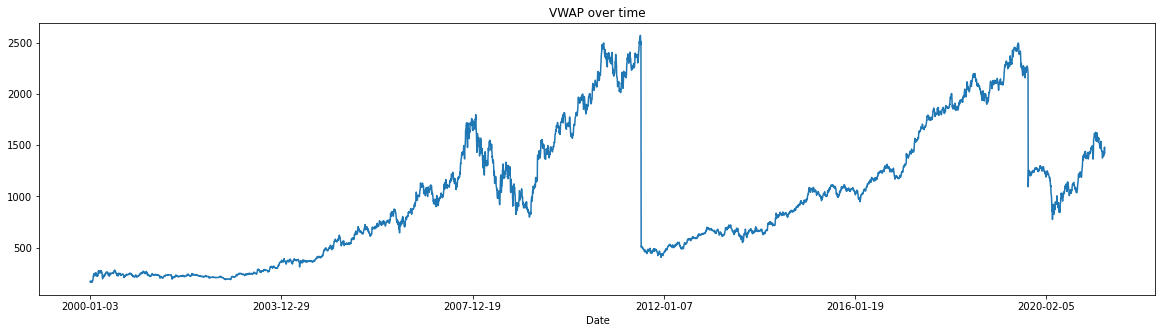

In [206]:
# Using the pandas library

plt.rcParams['figure.figsize'] = (20, 5)
plt.title('VWAP over time')
df.VWAP.plot() ;

In [207]:
# A pro technique would be to use plotly for interactive visual
fig = px.line(df, x='Date', y='VWAP', title='Time Series with Selectors')

fig.update_xaxes(
    rangeslider_visible=False,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Observartion
- Steady increase in stock price till july 2011.
- The stock fell considerably and on the rise again till March 2020.
- The stock again see a sharp fall in 2020. Can this be due to covid, let us check

In [208]:
# Splitting the date column to extract year, month, week and day
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["Year"]= df.Date.dt.year
df["day_of_week"] = df.Date.dt.dayofweek

#Below code block is used to plot the graph
fig = go.Figure([go.Scatter(x=df.loc[df["Year"] == 2020].Date,y=df.loc[df["Year"] == 2020].VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



It is evident that stock price felt the pressure during the Covid times

## 3.2 Plotting the moving average

While we analysising the stocks it would be good point to have a look on the moving average to understand the dips and high level. Traders prefer the following moving averages while making a call to buys or sell the stock

- 50 day MA
- 100 day MA
- 200 day MA

In [209]:
df.reset_index(drop=True, inplace=True)
numbers = df.High

window_size = 200

i = 0
moving_averages = []
while i < len(numbers) - window_size + 1:
    this_window = numbers[i : i + window_size]


    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1

print(moving_averages)

[244.08050000000006, 244.46550000000008, 244.78275000000008, 245.1332500000001, 245.5032500000001, 245.87325000000007, 246.19000000000008, 246.5955000000001, 247.03025000000008, 247.45300000000006, 247.87800000000007, 248.24950000000007, 248.62100000000007, 248.97550000000007, 249.30125000000007, 249.5702500000001, 249.78925000000007, 249.92625000000007, 249.95900000000006, 250.01400000000004, 249.98875000000007, 249.92875000000006, 249.77750000000003, 249.67250000000004, 249.66200000000003, 249.54800000000003, 249.40425000000008, 249.23175000000006, 249.05550000000005, 248.95750000000007, 248.91250000000008, 248.83875000000006, 248.7040000000001, 248.5050000000001, 248.3895000000001, 248.24950000000013, 248.15700000000012, 248.1055000000001, 248.1152500000001, 248.1652500000001, 248.2002500000001, 248.1652500000001, 248.09400000000005, 247.9247500000001, 247.66850000000014, 247.29600000000013, 247.05650000000009, 246.75700000000012, 246.45700000000008, 246.26675000000006, 246.01800000

In [210]:
len(series)

5107

In [213]:
df.shape

(5306, 18)

In [212]:
series = pd.Series(moving_averages, name="200_MA")
df = pd.concat([df, series], axis=1)

In [214]:
df['200_MA'] = df['200_MA'].shift(200)

In [216]:
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,month,week,day,Year,day_of_week,200_MA
Date,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,1,1,3,2000,0,NaN
2000-01-04,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,1,1,4,2000,1,NaN
2000-01-05,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,1,1,5,2000,2,NaN
2000-01-06,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,1,1,6,2000,3,NaN
2000-01-07,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,1,1,7,2000,4,NaN


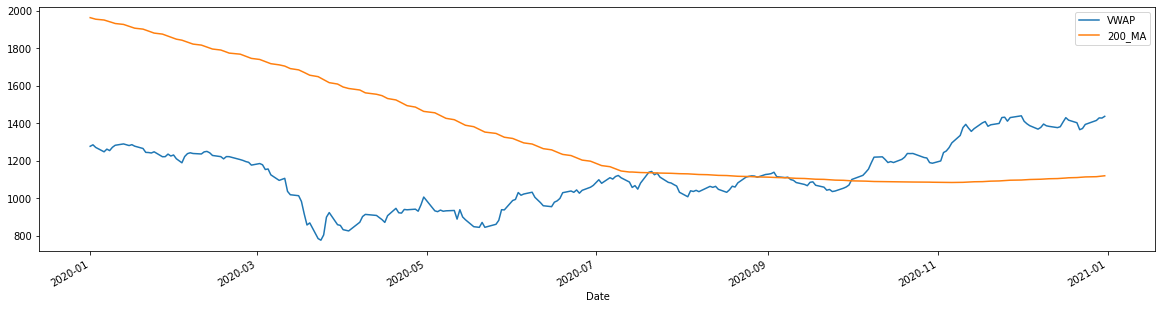

In [221]:
df.loc[df["Year"] == 2020][['VWAP', '200_MA']].plot()
# df[['VWAP', '200_MA']].plot()

In [114]:
fig = go.Figure([go.Scatter(x=df.loc[df["Year"] == 2020].Date,y=df.loc[df["Year"] == 2020].VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)

fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

In [103]:
fig = go.Figure([go.Scatter(x=df.loc[df["Year"] == 2020].Date,y=df.loc[df["Year"] == 2020]['200_MA'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

In [111]:
df.loc[df["Year"] == 2020].Date

4974   2020-01-01
4975   2020-01-02
4976   2020-01-03
4977   2020-01-06
4978   2020-01-07
          ...    
5221   2020-12-24
5222   2020-12-28
5223   2020-12-29
5224   2020-12-30
5225   2020-12-31
Name: Date, Length: 252, dtype: datetime64[ns]

In [107]:
sns.lineplot(df, x=df.loc[df["Year"] == 2020].Date, y=df.loc[df["Year"] == 2020]['200_MA'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: ignored

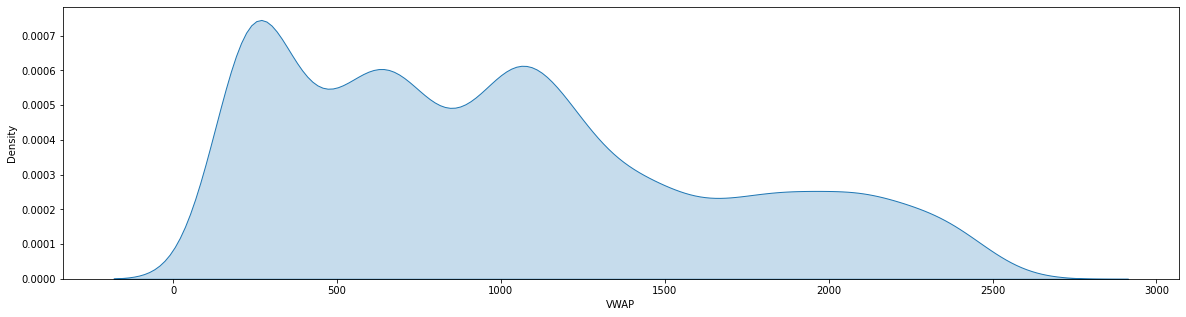

In [16]:
sns.kdeplot(df['VWAP'],shade=True)

# 4: Covid Period and Recovery <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 5: Stationary Conversion <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 6: Implemneting XGBoost <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 7: Hyperparameter Tuning - XGBoost <a name="7"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 8: Auto Corelation <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [17]:
kaggle_url = 'https://www.kaggle.com/rohanrao/nifty50-stock-market-data?select=TITAN.csv'
od.download(kaggle_url)

Skipping, found downloaded files in "./nifty50-stock-market-data" (use force=True to force download)


In [18]:
file_path = '/content/nifty50-stock-market-data/TITAN.csv'
df = pd.read_csv(file_path)

df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,TITAN,EQ,144.95,146.0,156.45,146.0,155.00,155.70,154.36,23000,3.550370e+11,NaN,NaN,NaN
1,2000-01-04,TITAN,EQ,155.70,152.0,152.00,144.0,148.05,147.40,146.72,26300,3.858700e+11,NaN,NaN,NaN
2,2000-01-05,TITAN,EQ,147.40,144.0,148.80,136.0,139.95,138.40,142.95,20600,2.944850e+11,NaN,NaN,NaN
3,2000-01-06,TITAN,EQ,138.40,142.0,149.50,141.0,149.50,149.50,147.87,31600,4.672750e+11,NaN,NaN,NaN
4,2000-01-07,TITAN,EQ,149.50,149.5,153.00,145.0,147.75,146.35,148.63,36600,5.439965e+11,NaN,NaN,NaN


In [19]:
## Visualize the time series

titan_opening_price = df[['Date', 'VWAP']]

titan_opening_price.set_index('Date', inplace=True)

titan_opening_price.index = pd.to_datetime(titan_opening_price.index, format="%Y-%m-%d")

titan_opening_price.head()

,VWAP
Date,
2000-01-03,154.36
2000-01-04,146.72
2000-01-05,142.95
2000-01-06,147.87
2000-01-07,148.63


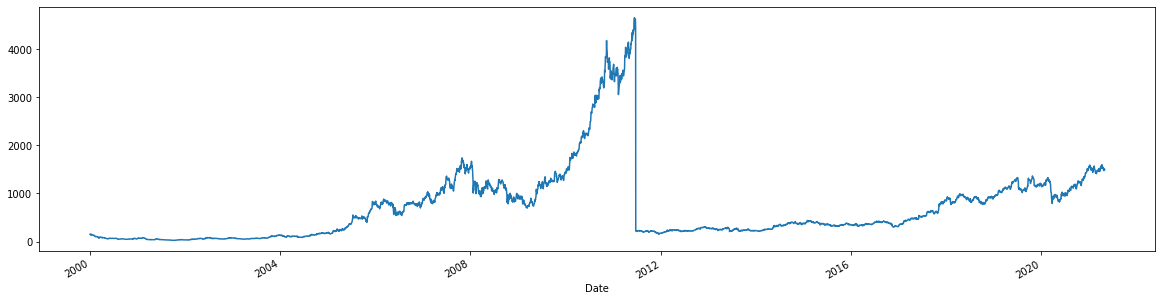

In [20]:
# visualize the data
plt.rcParams['figure.figsize'] = (20, 5)
titan_opening_price.VWAP.plot() ;

In [21]:
## testing for stationary
test_result=adfuller(titan_opening_price['VWAP'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Open):
    result=adfuller(Open)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [22]:
adfuller_test(titan_opening_price['VWAP'])

ADF Test Statistic : -3.0084407302444482
p-value : 0.03411362579041567
#Lags Used : 6
Number of Observations Used : 5299
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [23]:
## Performing time series decomposition

result=seasonal_decompose(x=titan_opening_price['VWAP'].head(365), model='multiplicable', freq=30)

result.seasonal.plot();

TypeError: ignored

In [ ]:
result.trend.plot();

In [ ]:
result.plot()

As the seasonal and trend component is not varing expotentially, this seems to be addtivie time series.

In [ ]:
df.VWAP.plot(figsize=(14, 7))

In [ ]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

In [ ]:
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

In [ ]:
df_mean_3d.head(5)

In [ ]:
df_mean_7d

In [ ]:
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

In [ ]:
for feature in lag_features:
  print(feature)

In [ ]:
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

In [ ]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

In [ ]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

In [ ]:
df_valid

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

Facebook prophet

In [ ]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

In [ ]:
model_fbp.plot_components(forecast)

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

# 9: ARIMA <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 10: Facebook Prophet <a name="10"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 11: Summary <a name="11"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 12: Future Work <a name="12"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# 13: References <a name="13"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- https://www.kaggle.com/rohanrao/a-modern-time-series-tutorial/notebook
- https://www.kaggle.com/yashvi/time-series-analysis-and-forecasting-reliance
- https://www.kaggle.com/vikassingh1996/bajaj-stock-price-pred-xgb-fb-prophet-altair#XGBoost-Modeling-and-Forecasting
- https://www.kaggle.com/benroshan/reliance-nifty50-time-series-analysis#Model-building-Phase--Forecasting-&-Prediction